In [1]:
import os

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, SqrtStretch
import matplotlib.pyplot as plt
import numpy as np
import sunpy.map
import sunpy.io.fits
import pfsspy
import pfsspy.coords

# Representing PFSS Fieldlines as Coordinates

This example shows how to compute a PFSS solution from pfsspy, trace some field lines, and
overplot the traced field lines on an AIA 171 map.
Adapted from [this example in the `pfsspy` docs](https://pfsspy.readthedocs.io/en/stable/auto_examples/plot_aia_overplotting.html). This figure also appears in the SunPy version 1.0 paper which has recently been accepted for publication.

## Load GONG and AIA Data

First, load a GONG magnetic field map from 10 March 2019. This will serve as the inner boundary condition for our potential field extrapolation.

In [2]:
[[br, header]] = sunpy.io.fits.read('../data/190310t0014gong.fits')
# The mean is subtracted to enforce div(B) = 0 on the solar surface
br = br - np.mean(br)
# GONG maps have their LH edge at -180deg in Carrington Longitude so roll to get it at 0deg.
br = np.roll(br, header['CRVAL1'] + 180, axis=1)

Next, load the corresponding AIA 171 map and crop it to the active region we are interested in.

In [3]:
aia = sunpy.map.Map('../data/aia_lev1_171a_2019_03_10t00_00_09_35z_image_lev1.fits')
aia_submap = aia.submap(
    SkyCoord(Tx=300*u.arcsec, Ty=100*u.arcsec, frame=aia.coordinate_frame),
    SkyCoord(Tx=650*u.arcsec, Ty=450*u.arcsec, frame=aia.coordinate_frame),
)

## Field Extrapolation

Define the number of grid points in $\rho$ and the source surface radius, $r_b=2.5R_{\odot}$

In [4]:
nrho = 100
rss = 2.5

Construct an `Input` object that stores this information

In [5]:
pfss_input = pfsspy.Input(br, nrho, rss, dtime=aia_submap.date)

and then compute the potential field source surface solution from the GONG magnetic field input.

In [6]:
pfss_output = pfsspy.pfss(pfss_input)

## Tracing Field Lines

Construct a grid of seed points to trace some magnetic field lines. These seed points are grouped about the center of the active region.

In [7]:
center_hgc = aia_submap.center.transform_to('heliographic_carrington')
s, phi = np.meshgrid(
    np.linspace(np.sin(center_hgc.lat)-0.07, np.sin(center_hgc.lat)+0.03, 15),
    np.deg2rad(np.linspace(center_hgc.lon.to(u.deg) - 7*u.deg,
                           center_hgc.lon.to(u.deg)+3*u.deg, 15)),
)

Next, trace a field line for every seed point.

In [8]:
flines = []
r = 0.01
for _s, _phi in zip(s.ravel(), phi.ravel()):
    x0 = np.array(pfsspy.coords.strum2cart(r, _s, _phi))
    flines.append(pfss_output.trace(x0, atol=1e-9, rtol=1e-5))

Notice that these fieldlines that we traced are in the Heliographic Carrington (HGC) frame of the original GONG observation (though they have a Cartesian representation).

In [9]:
flines[0][:10]

<FieldLine (HeliographicCarrington: obstime=2019-03-10T00:00:09.350): (x, y, z) in m
    [(3.75048682e+08, 5.73413360e+08, 1.20557433e+08),
     (3.75069348e+08, 5.73417566e+08, 1.20553595e+08),
     (3.75584358e+08, 5.73522532e+08, 1.20454823e+08),
     (3.77403880e+08, 5.73895777e+08, 1.20053327e+08),
     (3.78390716e+08, 5.74099639e+08, 1.19798796e+08),
     (3.79449948e+08, 5.74319424e+08, 1.19494484e+08),
     (3.84587376e+08, 5.75394910e+08, 1.17501326e+08),
     (3.89097538e+08, 5.76240757e+08, 1.14963981e+08),
     (3.92547948e+08, 5.76866548e+08, 1.12296111e+08),
     (3.94419786e+08, 5.77267802e+08, 1.10397753e+08)]>

## Plotting

Finally, plot the AIA map, along with the traced magnetic field lines. Inside the loop the field lines are converted from the HGC frame of the GONG map to the helioprojective (HPC) frame of the AIA image, and then plotted on top of the map.

We only plot fieldlines inside the bounding box of the active region submap that we cut out from the original AIA image.

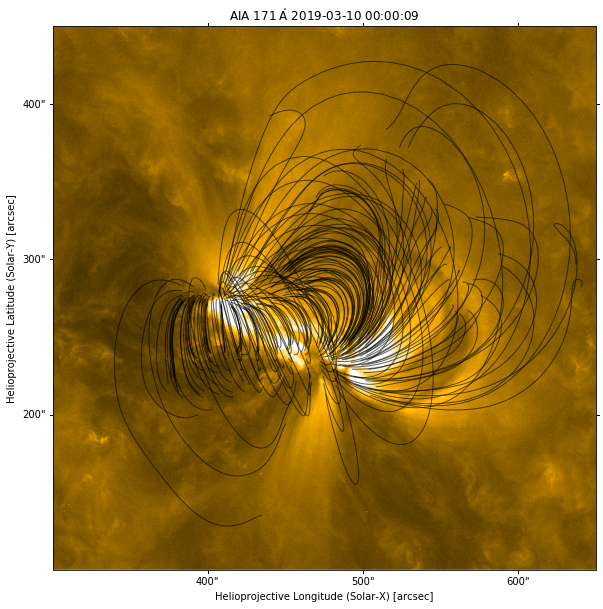

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection=aia_submap)
aia_submap.plot(
    axes=ax,
    title=True,
    norm=ImageNormalize(vmin=0, vmax=2e3, stretch=SqrtStretch())
)
ax.grid(False)
for f in flines:
    f_hpc = f.transform_to(aia_submap.coordinate_frame)
    # Only plot fieldlines in the AR
    if (
        np.any(f_hpc.Tx < aia_submap.bottom_left_coord.Tx) or
        np.any(f_hpc.Ty < aia_submap.bottom_left_coord.Ty) or
        np.any(f_hpc.Tx > aia_submap.top_right_coord.Tx) or
        np.any(f_hpc.Ty > aia_submap.top_right_coord.Ty)
    ):
        continue
    ax.plot_coord(f_hpc, alpha=0.6, linewidth=1, color='black')